### Demonstration notebook for SfM alignment dataset

This notebook demonstrates how to load and display the dataset.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

#### Loading the global SfM model

The 3d points in the global SfM model are stored as 64-bit floating point 3-vectors.

    x1,y1,z1,x2,y2,z2,...
    

In [2]:
points = np.fromfile('points.double3',dtype='float64')
points = points.reshape([-1,3])
points.shape

(132994, 3)

The point cloud has a lot of outlier points in it.  The office scene is contained in a $[-3~3]^3$ box.

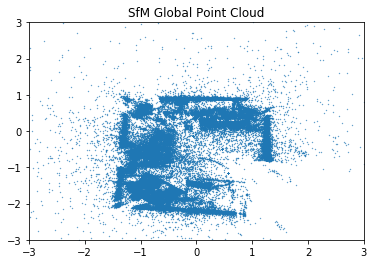

In [3]:
plt.scatter(points[:,0],points[:,1],s=0.1)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.title('SfM Global Point Cloud')
plt.show()

Each point in the global SfM model has an associated SIFT descriptor.  These are stored as 32-bit float 128-vectors.

In [4]:
descriptors = np.fromfile('descriptors.float128',dtype='float32')
descriptors = descriptors.reshape([-1,128])
descriptors.shape

(132994, 128)

#### Loading a SLAM sequence

In [5]:
def skew3(x):
    A = np.zeros((3,3))
    A[0,1] = -x[2]
    A[0,2] = x[1]
    A[1,0] = x[2]
    A[1,2] = -x[0]
    A[2,0] = -x[1]
    A[2,1] = x[0]
    return A

def so3exp(r):
    theta = np.sqrt(np.sum(r**2))
    if theta < 1e-10:
        return np.eye(3)
    K = skew3(r/theta)
    R = np.eye(3)+np.sin(theta)*K+(1-np.cos(theta))*np.dot(K,K)
    return R

class Keyframe:
    def __init__(self,directory,index):
        basepath = '%s/frame%02d'%(directory,index)
        self.descriptors = np.fromfile(basepath + '.descriptors.float128',dtype='float32').reshape([-1,128])
        self.features = np.fromfile(basepath + '.features.float2',dtype='float32').reshape([-1,2])
        self.gt_c = np.fromfile(basepath + '.groundtruth_position.double3',dtype='float64')
        self.gt_r = np.fromfile(basepath + '.groundtruth_rotation.double3',dtype='float64')
        self.gt_R = so3exp(self.gt_r)
        self.gt_t = -np.dot(self.gt_R, self.gt_c)
        self.slam_t = np.fromfile(basepath + '.slampose_translation.double3',dtype='float64')
        self.slam_r = np.fromfile(basepath + '.slampose_rotation.double3',dtype='float64')
        self.slam_R = so3exp(self.slam_r)
        self.slam_c = -np.dot(self.slam_R.T, self.slam_t)
    
    def get_matches(self,descriptors):
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(self.descriptors,descriptors,k=2)
        
        good = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good.append(m)
        return good
        
def load_frames(path):
    """ Load all keyframes in a directory."""
    frames = []
    index = 0
    while True:
        try:
            frames.append(Keyframe(path,index))
            index += 1
        except:
            break
    return frames


We will load the office3 dataset as an example.

In [6]:
frames = load_frames('office3')

Here we plot the ground truth keyframe positions on top of the SfM point cloud.

In [7]:
gt_c = np.stack([frame.gt_c for frame in frames])

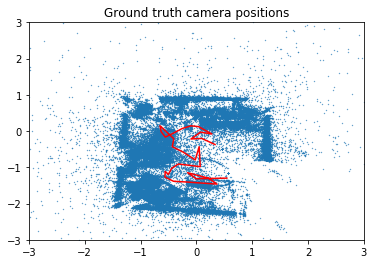

In [8]:
plt.scatter(points[:,0],points[:,1],s=0.1)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.plot(gt_c[:,0],gt_c[:,1],'r-')
plt.title('Ground truth camera positions')
plt.show()

Here is a plot of the camera trajectory as estimated by the SLAM system.  Note that the coordinate system is not aligned with the ground truth.

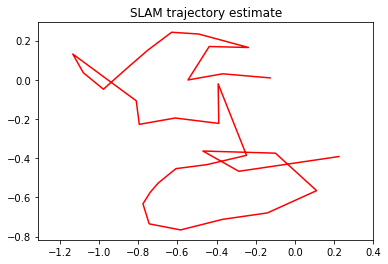

In [9]:
slam_c = np.stack([frame.slam_c for frame in frames])
plt.plot(slam_c[:,0],slam_c[:,1],'r-')
plt.axis('equal')
plt.title('SLAM trajectory estimate')
plt.show()

#### Test absolute orientation registration of SLAM poses and GT poses

Now we will register the ground truth and SLAM trajectories using a similarity transformation and compute the resulting mean-squared error.

In [10]:
# code from https://github.com/raulmur/evaluate_ate_scale/blob/master/evaluate_ate_scale.py
def align(model,data):
    """Align two trajectories using the method of Horn (closed-form).
    
    Input:
    model -- first trajectory (3xn)
    data -- second trajectory (3xn)
    
    Output:
    rot -- rotation matrix (3x3)
    trans -- translation vector (3x1)
    trans_error -- translational error per point (1xn)
    
    """
    np.set_printoptions(precision=3,suppress=True)
    model_zerocentered = model - model.mean(1)
    data_zerocentered = data - data.mean(1)
    
    W = np.zeros( (3,3) )
    for column in range(model.shape[1]):
        W += np.outer(model_zerocentered[:,column],data_zerocentered[:,column])
    U,d,Vh = np.linalg.linalg.svd(W.transpose())
    S = np.matrix(np.identity( 3 ))
    if(np.linalg.det(U) * np.linalg.det(Vh)<0):
        S[2,2] = -1
    rot = U*S*Vh

    rotmodel = rot*model_zerocentered
    dots = 0.0
    norms = 0.0

    for column in range(data_zerocentered.shape[1]):
        dots += np.dot(data_zerocentered[:,column].transpose(),rotmodel[:,column])
        normi = np.linalg.norm(model_zerocentered[:,column])
        norms += normi*normi

    s = float(dots/norms)    

    trans = data.mean(1) - s*rot * model.mean(1)
    
    model_aligned = s*rot * model + trans
    alignment_error = model_aligned - data
    
    trans_error = np.sqrt(np.sum(np.multiply(alignment_error,alignment_error),0)).A[0]
        
    return rot,trans,trans_error, s


In [11]:
first_xyz = np.matrix(gt_c).T
second_xyz = np.matrix(slam_c).T
rot,trans,trans_error,scale = align(second_xyz,first_xyz)

In [12]:
second_xyz_aligned = scale * rot * second_xyz + trans
slam_c_aligned = np.array(second_xyz_aligned.T)

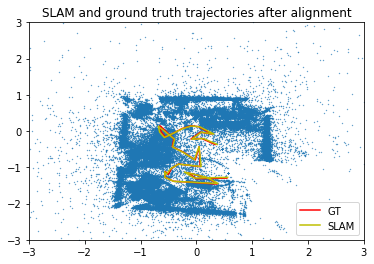

In [13]:
plt.scatter(points[:,0],points[:,1],s=0.1)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.plot(gt_c[:,0],gt_c[:,1],'r-')
plt.plot(slam_c_aligned[:,0],slam_c_aligned[:,1],'y-')
plt.title('SLAM and ground truth trajectories after alignment')
plt.legend(['GT','SLAM'])
plt.show()

In [14]:
mse = np.mean((gt_c-slam_c_aligned)**2)
print('Mean squared error after alignment: %f'%mse)

Mean squared error after alignment: 0.000209
